In [116]:
import pandas as pd
import numpy as np
import scipy.signal
import scipy.stats
from scipy.optimize import curve_fit
import sklearn
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from IPython.display import display, clear_output
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation, Masking, Dropout, BatchNormalization,Conv1D
import keras.optimizers 
from keras import callbacks

In [79]:
output = ["RUL"]
index =  ["UnitNumber","Cycle"]
ops = ["OpSet"+str(i) for i in range(1,4)]
sensors =["SensorMeasure"+str(i) for i in range(1,22)]
inputs = index + ops + sensors
cols_to_drop = ['OpSet3', 'SensorMeasure1', 'SensorMeasure5', 'SensorMeasure6', 'SensorMeasure10', 'SensorMeasure14',
     'SensorMeasure16', 'SensorMeasure18', 'SensorMeasure19']

train = pd.read_csv('train_FD001.txt',delim_whitespace=True,names=inputs)
test = pd.read_csv('test_FD001.txt', delim_whitespace=True, names=inputs)

drop_cols = True
if(drop_cols == True):
        train = train.drop(cols_to_drop, axis = 1)
        test = test.drop(cols_to_drop, axis = 1)

RULt = pd.read_csv('RUL_FD001.txt', delim_whitespace=True,names=output)
RULt["UnitNumber"] = RULt.index    

In [47]:
RULt.head()

,RUL,UnitNumber
0,112,0
1,98,1
2,69,2
3,82,3
4,91,4


In [48]:
train.head()

,UnitNumber,Cycle,OpSet1,OpSet2,OpSet3,SensorMeasure1,SensorMeasure2,SensorMeasure3,SensorMeasure4,SensorMeasure5,...,SensorMeasure12,SensorMeasure13,SensorMeasure14,SensorMeasure15,SensorMeasure16,SensorMeasure17,SensorMeasure18,SensorMeasure19,SensorMeasure20,SensorMeasure21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [49]:
test.head()

,UnitNumber,Cycle,OpSet1,OpSet2,OpSet3,SensorMeasure1,SensorMeasure2,SensorMeasure3,SensorMeasure4,SensorMeasure5,...,SensorMeasure12,SensorMeasure13,SensorMeasure14,SensorMeasure15,SensorMeasure16,SensorMeasure17,SensorMeasure18,SensorMeasure19,SensorMeasure20,SensorMeasure21
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130


In [80]:
f = train.columns.drop(index)
scale = sklearn.preprocessing.MinMaxScaler(feature_range=(-1,1))
train[f] = scale.fit_transform(train[f])
test[f] = scale.fit_transform(test[f])
train.shape, test.shape

((20631, 17), (13096, 17))

In [84]:
seq_len = 50
mask = 0

def func_train(id_samples, seq_len, f):
    ###id_samples = train dataframe (samples)
    ###seq_len = look back period (time steps)
    ###seq_cols = feature columns (features)  
    data = id_samples[f].values
    size = data.shape[0]
    lstm_seq=[]
    for start, stop in zip(range(0, size-seq_len+1), range(seq_len, size+1)):
        lstm_seq.append(data[start:stop, :])
        
    return lstm_seq

train_x=np.concatenate([func_train(train[train['UnitNumber']==unit_id], seq_len, f) for unit_id in train['UnitNumber'].unique()])
print(train_x.shape)

def func_y(id_samples, seq_len, f):
    data = id_samples[f].values
    size = data.shape[0]
    return data[seq_len-1:size+1]

train_y = np.concatenate([func_y(train[train['UnitNumber']==unit_id], seq_len, "Cycle") for unit_id in train['UnitNumber'].unique()])
print(train_y.shape)

def func_test(id_samples, seq_length, f, mask_value):

    mask_n = pd.DataFrame(np.zeros((seq_len-1,id_samples.shape[1])),columns=id_samples.columns)
    mask_n[:] = mask
    
    id_samples = mask_n.append(id_samples,ignore_index=True)
    
    data = id_samples[f].values
    size = data.shape[0]
    lstm_seq=[]
    
    lstm_seq.append(data[size-seq_len:size, :])
    
    return lstm_seq

test_x=np.concatenate([func_test(test[test['UnitNumber']==unit_id], seq_len, f, mask) for unit_id in test['UnitNumber'].unique()])
print(test_x.shape)

test_y = RULt.RUL.values
test_y.shape

(15731, 50, 15)
(15731,)
(100, 50, 15)


/var/tmp/ipykernel_1086364/1387559689.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_samples = mask_n.append(id_samples,ignore_index=True)


(100,)

In [113]:
test_y

array([112,  98,  69,  82,  91,  93,  91,  95, 111,  96,  97, 124,  95,
       107,  83,  84,  50,  28,  87,  16,  57, 111, 113,  20, 145, 119,
        66,  97,  90, 115,   8,  48, 106,   7,  11,  19,  21,  50, 142,
        28,  18,  10,  59, 109, 114,  47, 135,  92,  21,  79, 114,  29,
        26,  97, 137,  15, 103,  37, 114, 100,  21,  54,  72,  28, 128,
        14,  77,   8, 121,  94, 118,  50, 131, 126, 113,  10,  34, 107,
        63,  90,   8,   9, 137,  58, 118,  89, 116, 115, 136,  28,  38,
        20,  85,  55, 128, 137,  82,  59, 117,  20])

In [95]:
nb_features = train_x.shape[2]
nb_out = 1

history = keras.callbacks.History()

model = Sequential()
model.add(LSTM(
         units=100,
         return_sequences=True,
         input_shape=(seq_len, nb_features)))
model.add(Dropout(0.2))
model.add(LSTM(
          units=100,
          return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation='relu'))
model.add(Activation("relu"))
model.compile(loss="mse", optimizer="rmsprop", metrics=['mse'])

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 50, 100)           46400     
_________________________________________________________________
dropout_12 (Dropout)         (None, 50, 100)           0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dropout_13 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 101       
_________________________________________________________________
activation_6 (Activation)    (None, 1)                 0         
Total params: 126,901
Trainable params: 126,901
Non-trainable params: 0
________________________________________________

In [96]:
model.fit(train_x, train_y, epochs=100, batch_size=32, validation_split=0.1, verbose=1,
          callbacks = [history, keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')])

Epoch 1/100
443/443 [==============================] - 41s 87ms/step - loss: 12850.5723 - mse: 12850.5723 - val_loss: 15864.2305 - val_mse: 15864.2305
Epoch 2/100
443/443 [==============================] - 36s 80ms/step - loss: 6162.5205 - mse: 6162.5205 - val_loss: 8918.8623 - val_mse: 8918.8623
Epoch 3/100
443/443 [==============================] - 35s 80ms/step - loss: 3145.7603 - mse: 3145.7603 - val_loss: 6029.5176 - val_mse: 6029.5176
Epoch 4/100
443/443 [==============================] - 36s 80ms/step - loss: 1778.4790 - mse: 1778.4790 - val_loss: 4098.9863 - val_mse: 4098.9863
Epoch 5/100
443/443 [==============================] - 36s 80ms/step - loss: 1341.8502 - mse: 1341.8502 - val_loss: 3537.1824 - val_mse: 3537.1824
Epoch 6/100
443/443 [==============================] - 36s 81ms/step - loss: 1206.5592 - mse: 1206.5592 - val_loss: 3347.3115 - val_mse: 3347.3115
Epoch 7/100
443/443 [==============================] - 36s 80ms/step - loss: 1128.9242 - mse: 1128.9242 - val_loss

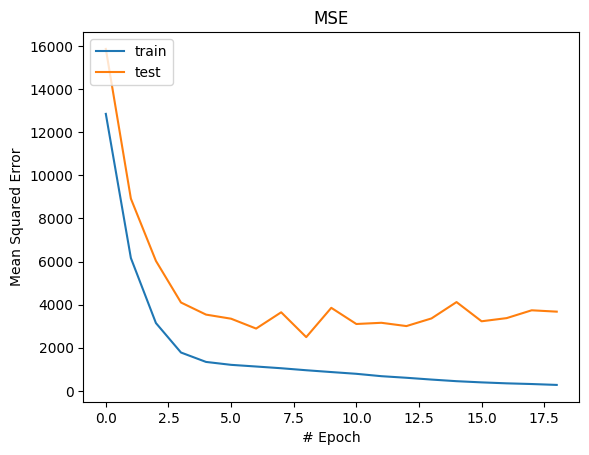

In [97]:
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('MSE')
plt.ylabel('Mean Squared Error')
plt.xlabel('# Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [98]:
scores = model.evaluate(train_x, train_y, verbose=1, batch_size=200)
print('MSE: {}'.format(scores[1]))

scores_test = model.evaluate(test_x, test_y, verbose=2)
print('MSE: {}'.format(scores_test[1]))

79/79 [==============================] - 7s 82ms/step - loss: 529.4332 - mse: 529.4332
MSE: 529.4332275390625
4/4 - 0s - loss: 13583.9697 - mse: 13583.9697
MSE: 13583.9697265625


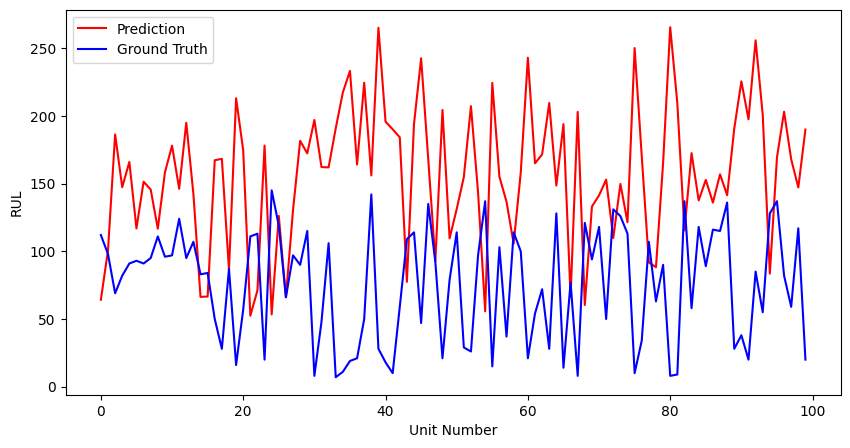

In [99]:
pred_test = model.predict(test_x, verbose=0)

plt.figure(figsize=(10,5))
plt.plot(pred_test, color='red', label='Prediction')
plt.plot(test_y, color='blue', label='Ground Truth')
plt.ylabel("RUL")
plt.xlabel("Unit Number")
plt.legend(loc='upper left')
plt.show()

In [124]:
nb_features = train.shape[1]
nb_out = 1
numHiddenUnits = 100;

model = Sequential()
model.add(keras.layers.Conv1D(5,32,padding='same',input_shape=(train.shape[1], 1)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.ReLU())
model.add(keras.layers.Conv1D(7,64,padding='same'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.ReLU())
model.add(keras.layers.Conv1D(11,128,padding='same'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.ReLU())
model.add(keras.layers.Conv1D(13,256,padding='same'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.ReLU())
model.add(keras.layers.Conv1D(15,512,padding='same'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.ReLU())
model.add(Dense(numHiddenUnits, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_out))
model.add(Activation("relu"))
model.compile(loss="mse", optimizer="adam", metrics=['mse'])

model.summary()





Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_16 (Conv1D)           (None, 17, 5)             165       
_________________________________________________________________
batch_normalization_15 (Batc (None, 17, 5)             20        
_________________________________________________________________
re_lu_15 (ReLU)              (None, 17, 5)             0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 17, 7)             2247      
_________________________________________________________________
batch_normalization_16 (Batc (None, 17, 7)             28        
_________________________________________________________________
re_lu_16 (ReLU)              (None, 17, 7)             0         
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 17, 11)          